# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, plot_ptt_paths

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [2]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

# v = 1
v = 2

# crustal_thickness_comparison = False
crustal_thickness_comparison = True

if(crustal_thickness_comparison == True):
    print(f"Comparing different crustal thickness with velocity of {v} cm/yr")
else:
    print(f"Comparing changing in lithospheric thickness with velocity of {v} cm/yr")

if(crustal_thickness_comparison == False):
    if(v==1):
        scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
                ]
    elif(v==2):

        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
                    ]
else:
    if(v==1):
        scenarios = [
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
                f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
                ]
    if(v==2):
        scenarios = [
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
                    f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
                    ]


trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")

Comparing different crustal thickness with velocity of 2 cm/yr


RH_Hc35vsHc40_v2_Tt_Pt_evolution


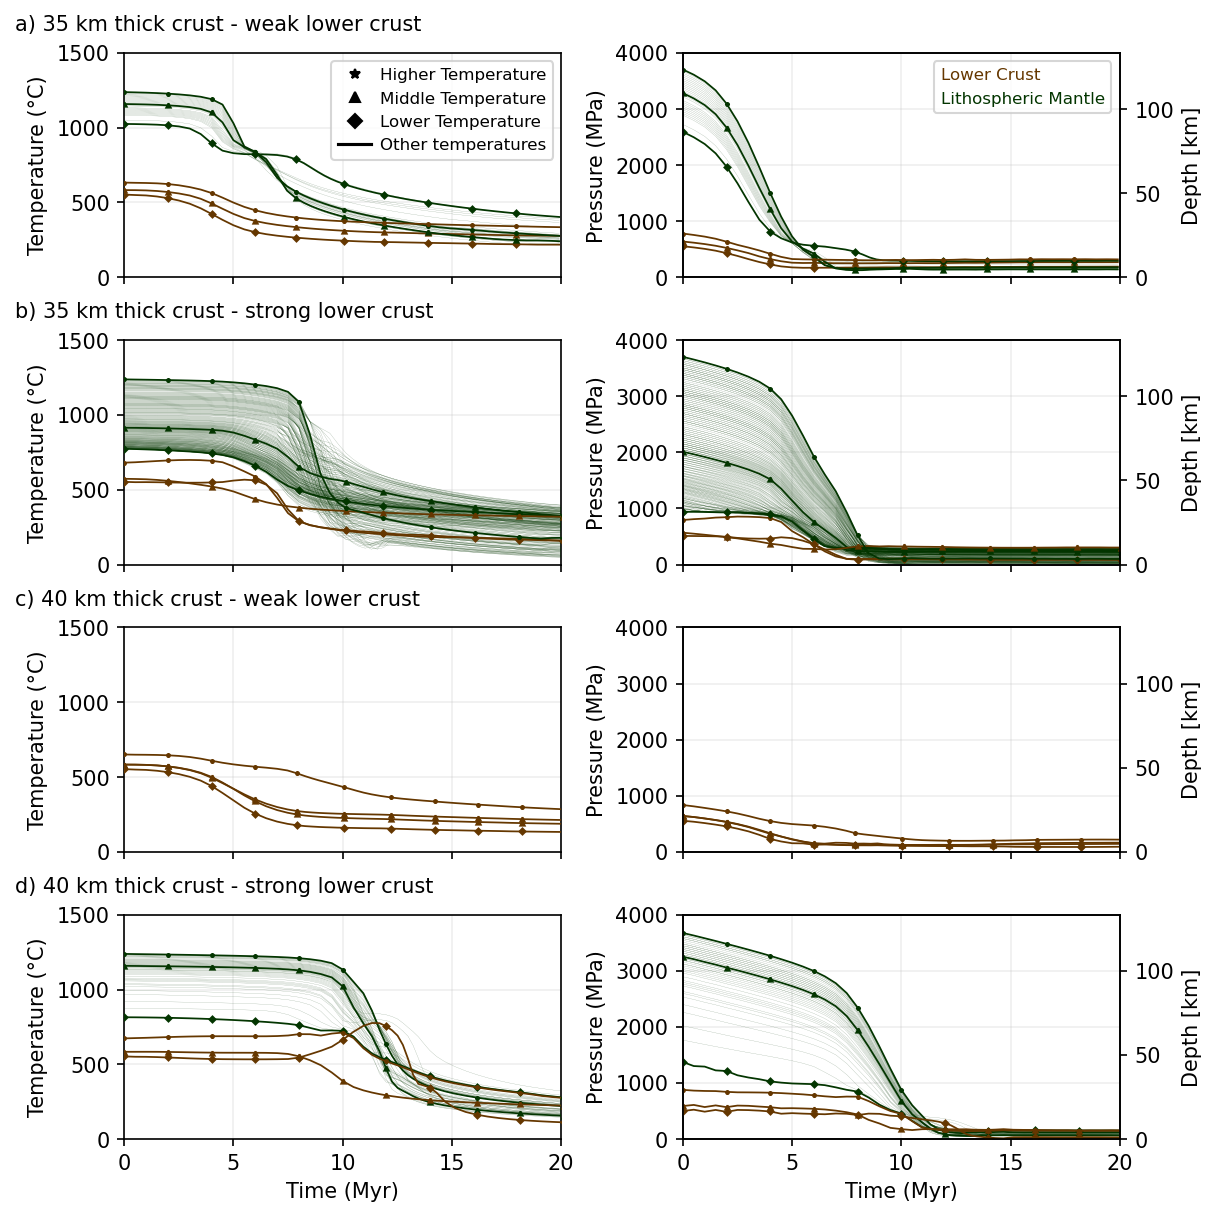

In [4]:
def take_three_particles(layer_codes, particles_layers, T_initial):
    if(len(layer_codes) == 1):
        cond = particles_layers == layer_codes[0]
    else:
        cond = (particles_layers == layer_codes[0]) | (particles_layers == layer_codes[1])

    particles_layer = particles_layers[cond]

    T_initial_layer = T_initial[cond] #initial temperature of lithospheric mantle particles
    T_initial_layer_sorted = np.sort(T_initial_layer)

    Ti_layer_max = np.max(T_initial_layer_sorted)
    mid_index = len(T_initial_layer_sorted)//2
    Ti_layer_mid = T_initial_layer_sorted[mid_index]
    Ti_layer_min = np.min(T_initial_layer_sorted)

    cond2plot = (T_initial == Ti_layer_min) | (T_initial == Ti_layer_mid) | (T_initial == Ti_layer_max)

    return cond2plot, cond, Ti_layer_max, Ti_layer_mid, Ti_layer_min, len(particles_layer)

def plot_PT_evolution(axT, axP, time, P, T, color='xkcd:light gray', linewidth=1, markersize=2, alpha=1.0, zorder=60, plot_each_5Myr=True, marker='.'):
    axT.plot(time, T[::, particle], '-', color=color, linewidth=linewidth, alpha=alpha, zorder=zorder) #PTt path
    axP.plot(time, P[::, particle], '-', color=color, linewidth=linewidth, alpha=alpha, zorder=zorder) #PTt path

    if(plot_each_5Myr == True):
        for j in np.arange(0, time[-1], 2):
            idx = find_nearest(time, j)
            axT.plot(time[idx], T[idx, particle], marker, color=color, markersize=2, zorder=zorder)
            axP.plot(time[idx], P[idx, particle], marker, color=color, markersize=2, zorder=zorder)

trackdatasets = [trackdataset0, trackdataset1, trackdataset2, trackdataset3]#, trackdataset4, trackdataset5, trackdataset6, trackdataset7]

asthenosphere_code = 0 #asthenosphere
mantle_lithosphere1_code = 1
mantle_lithosphere2_code = 3 #lithospheric mantle
lower_crust_code = 4 #lower crust
upper_crust_code = 5 #upper crust

linewidth = 0.85
markersize = 30
color_lower_crust='xkcd:brown'

fig, axs = plt.subplots(4, 2 , figsize=(8, 8), dpi=150, constrained_layout=True, sharex=True)
axs = axs.flatten()

for trackdataset, i in zip(trackdatasets, range(len(trackdatasets))):
    x_track = trackdataset.xtrack.values[::-1]
    z_track = trackdataset.ztrack.values[::-1]
    P = trackdataset.ptrack.values[::-1]
    T = trackdataset.ttrack.values[::-1]
    time = trackdataset.time.values[::-1]
    steps = trackdataset.step.values[::-1]
    n = int(trackdataset.ntracked.values)
    nTotal = np.size(x_track)
    steps = nTotal//n #number of steps

    x_track = np.reshape(x_track,(steps,n))
    z_track = np.reshape(z_track,(steps,n))
    P = np.reshape(P,(steps,n))
    T = np.reshape(T,(steps,n))
    particles_layers = trackdataset.particles_layers.values[::-1] #code of the tracked layer

    T_initial = T[0] #initial temperature of particles
    P_initial = P[0] #initial pressure of particles
    
    if(asthenosphere_code in particles_layers):
        cond_ast = particles_layers == asthenosphere_code #condition to select asthenospheric particles
        particles_ast = particles_layers[cond_ast]
        # print(f"N asthenospheric particles: {len(particles_ast)}")
        #Selecting particles with P0 <= 4000 MPa
        cond_ast2plot = P_initial <= 4000
        plot_asthenosphere_particles = True

        color_asthenosphere = 'xkcd:violet'
        ast_marker = '.'
    else:
        plot_asthenosphere_particles = False
        cond_ast2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if((mantle_lithosphere1_code in particles_layers) | (mantle_lithosphere2_code in particles_layers)):
        cond_mantle_lithosphere2plot, cond_mantle_lithosphere, Ti_mlit_max, Ti_mlit_mid, Ti_mlit_min, n_mantle_lithosphere = take_three_particles([mantle_lithosphere1_code,mantle_lithosphere2_code],
                                                                                                particles_layers, T_initial)
        
        # print(f"N lithospheric mantle particles: {n_mantle_lithosphere}")

        plot_mantle_lithosphere_particles = True
        
        dict_mantle_lithosphere_markers = {Ti_mlit_max: '*',
                                            Ti_mlit_mid: '^',
                                            Ti_mlit_min: 'D'}

        # dict_mantle_lithosphere_colors = {Ti_mlit_min: 'xkcd:cerulean blue',
        #                                 Ti_mlit_mid: 'xkcd:scarlet',
        #                                 Ti_mlit_max: 'xkcd:dark green'}

        color_mantle_lithosphere = 'xkcd:dark green'

        dict_mantle_lithosphere_colors = {Ti_mlit_min: color_mantle_lithosphere,
                                        Ti_mlit_mid: color_mantle_lithosphere,
                                        Ti_mlit_max: color_mantle_lithosphere}
    else:
        plot_mantle_lithosphere_particles = False
        cond_mantle_lithosphere2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if(lower_crust_code in particles_layers):
        cond_lower_crust2plot, cond_lower_crust, Ti_crust_max, Ti_crust_mid, Ti_crust_min, n_lower_crust = take_three_particles([lower_crust_code],
                                                                                                particles_layers, T_initial)

        # print(f"N crustal particles: {n_lower_crust}")

        dict_lower_crust_markers = {Ti_crust_max: '*',
                                    Ti_crust_mid: '^',
                                    Ti_crust_min: 'D'}

        plot_lower_crust_particles = True

    else:
        plot_lower_crust_particles = False
        cond_lower_crust2plot = np.arange(0, n, 1) == np.arange(0,n,1) + 1

    plot_other_particles = True #plot particles that are not in the other categories

    for particle, particle_layer in zip(range(n), particles_layers):
                #Plot particles in prop subplot
        if((plot_lower_crust_particles == True) & (particle_layer == lower_crust_code)):
            if(cond_lower_crust2plot[particle] == True):
                marker = dict_lower_crust_markers[T_initial[particle]]
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P, T, color=color_lower_crust, linewidth=linewidth, markersize=markersize, zorder=61, marker=marker)

        if((plot_mantle_lithosphere_particles == True) & ((particle_layer == mantle_lithosphere1_code) | (particle_layer == mantle_lithosphere2_code))):
            if(cond_mantle_lithosphere2plot[particle] == True):
                color = dict_mantle_lithosphere_colors[T_initial[particle]]
                marker = dict_mantle_lithosphere_markers[T_initial[particle]]
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P, T, color=color, linewidth=linewidth, markersize=markersize, zorder=61, marker=marker)
            else:
                if(plot_other_particles == True):
                    color = color_mantle_lithosphere
                    plot_PT_evolution(axs[2*i], axs[2*i+1], time, P, T, color=color, linewidth=0.1, markersize=markersize, alpha=0.5, zorder=60, plot_each_5Myr=False)

        if((plot_asthenosphere_particles == True) & (particle_layer == asthenosphere_code)):
            if(cond_ast2plot[particle] == True):
                plot_PT_evolution(axs[2*i], axs[2*i+1], time, P, T, color=color_asthenosphere, linewidth=0.1, markersize=markersize, zorder=61, marker=marker, plot_each_5Myr=False)


# axs[0][0].grid('-k', alpha=0.2)
ylims = np.array([0, 4000])
for ax, number in zip(axs, range(len(axs))):
    ax.grid('-k', alpha=0.2)
    # ax.text(-0.2, 1.1, f"{string.ascii_lowercase[number]})", transform=ax.transAxes, fontsize=12)
    ax.set_xlim(0, 40) if v== 1 else ax.set_xlim(0, 20)
    ax.set_ylim(0, 1500) if ax.get_subplotspec().is_first_col() else ax.set_ylim(ylims)
    ax.set_xlabel('Time (Myr)') if  ax.get_subplotspec().is_last_row() else ax.set_xlabel('')
    ax.set_ylabel('Temperature (°C)') if ax.get_subplotspec().is_first_col() else ax.set_ylabel('Pressure (MPa)')

    if ax.get_subplotspec().is_last_col():
        ax1 = ax.twinx()
        ax1.set_ylim(ylims/30)
        # ax1.tick_params(axis='y', labelright=False, labelleft=True, labelsize=fsize)
        ax1.set_ylabel('Depth [km]')
        ax1.tick_params(axis='y')

#creating legends
idx_legend = 0
axs = axs.flatten()
axs[idx_legend].plot([-10,-10], [-10,-10], '*', color='xkcd:black', markersize=5, label='Higher Temperature')
axs[idx_legend].plot([-10,-10], [-10,-10], '^', color='xkcd:black', markersize=5, label='Middle Temperature')
axs[idx_legend].plot([-10,-10], [-10,-10], 'D', color='xkcd:black', markersize=5, label='Lower Temperature')
axs[idx_legend].plot([-10,-10], [-10,-10], '-', color='xkcd:black', markersize=5, label='Other temperatures')
axs[idx_legend].legend(loc='upper right', fontsize=8, ncols=1, handletextpad=0.5)

idx_legend = 1
ax2 = axs[idx_legend].twinx()
ax2.axis('off')
ax2.plot([-10,-10], [-10,-10], '-', color=color_lower_crust, markersize=5, label='Lower Crust')
ax2.plot([-10,-10], [-10,-10], '-', color=color_mantle_lithosphere, markersize=5, label='Lithospheric Mantle')
ax2.plot([-10,-10], [-10,-10], '-', color=color_asthenosphere, markersize=5, label='Asthenosphere') if crustal_thickness_comparison == False else None

ax2.legend(loc='upper right', ncol=1, fontsize=8, handlelength=0, handletextpad=0, labelcolor='linecolor')

xpos = -0.25
ypos = 1.1

if(crustal_thickness_comparison == False):
    axs[0].text(xpos, ypos, 'a) Homogeneous - weak lower crust', transform=axs[0].transAxes, fontsize=10)
    axs[2].text(xpos, ypos, 'b) Homogeneous - strong lower crust', transform=axs[2].transAxes, fontsize=10)
    axs[4].text(xpos, ypos, 'c) Thinned - weak lower crust', transform=axs[4].transAxes, fontsize=10)
    axs[6].text(xpos, ypos, 'd) Thinned - strong lower crust', transform=axs[6].transAxes, fontsize=10)
    figname = f"RHvsRT_v{v}_Tt_Pt_evolution"
else:
    axs[0].text(xpos, ypos, 'a) 35 km thick crust - weak lower crust', transform=axs[0].transAxes, fontsize=10)
    axs[2].text(xpos, ypos, 'b) 35 km thick crust - strong lower crust', transform=axs[2].transAxes, fontsize=10)
    axs[4].text(xpos, ypos, 'c) 40 km thick crust - weak lower crust', transform=axs[4].transAxes, fontsize=10)
    axs[6].text(xpos, ypos, 'd) 40 km thick crust - strong lower crust', transform=axs[6].transAxes, fontsize=10)
    figname = f"RH_Hc35vsHc40_v{v}_Tt_Pt_evolution"
    
print(figname)

fig.savefig(f"figures/{figname}.pdf", dpi=300)
fig.savefig(f"figures/{figname}.png", dpi=300)